In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
mpl.rcParams.update(params)
plt.jet()

classes=np.array(['Peaks','Filaments','Sheets','Voids'])
np.set_printoptions(precision=4)

In [2]:
path = "../.."

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import pickle

# Claim 1 beta=2 Tree

Predicting Cosmic Web for lambda_th:0.1 Mr<-14 sigma:1.5
../../bsk_data/TNG/data_mock_Cr5_lth0.1_sm1.5_train.csv
../../bsk_data/TNG/data_mock_Cr5_lth0.1_sm1.5_test.csv
0.561
0.682
0.728
0.619
0.217
10


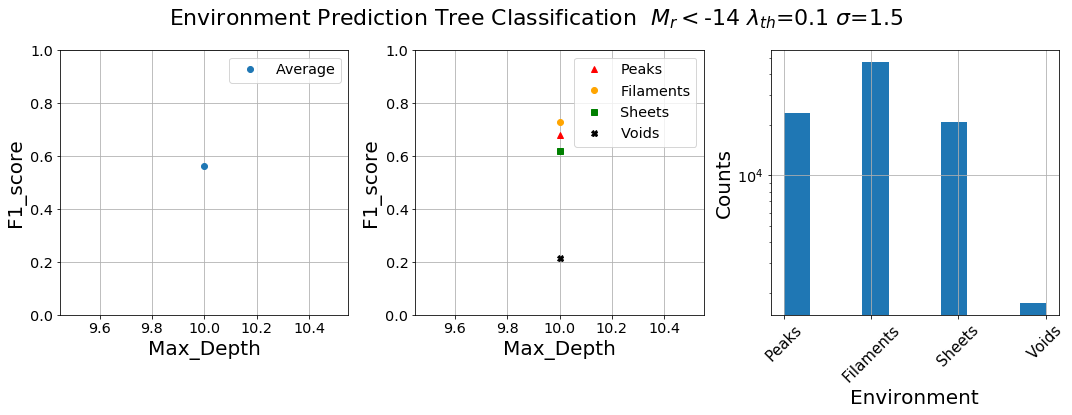

0.5591396092075741
0.6765707659975361
0.7353674880895316
0.60994128366066
0.2146788990825688


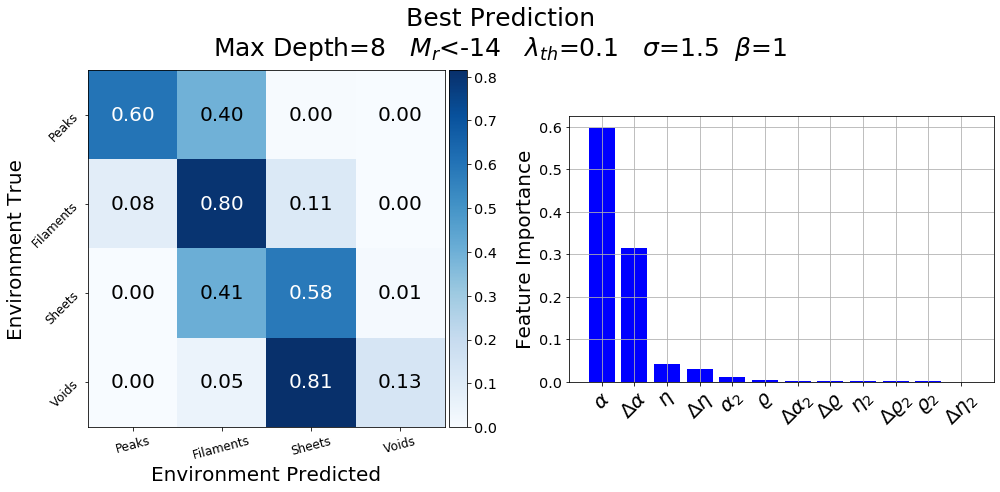

0.5591396092075741
0.6765707659975361
0.7353674880895316
0.60994128366066
0.2146788990825688


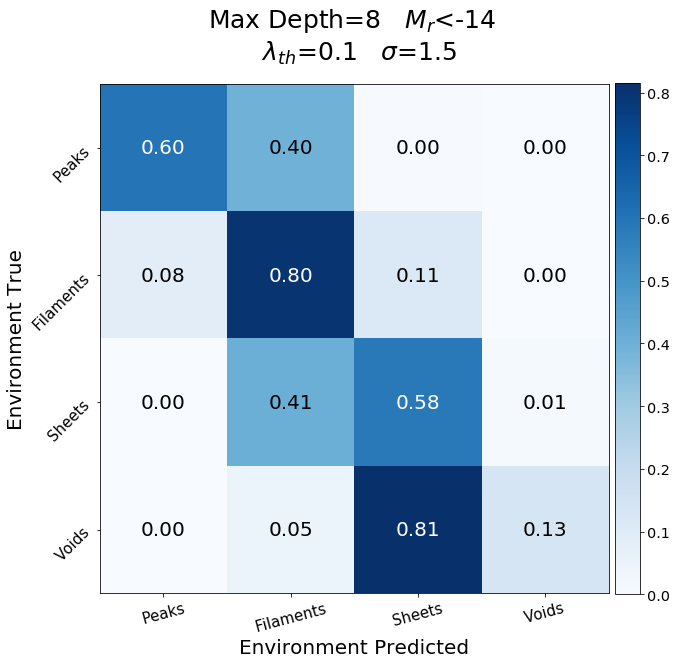

0.5591396092075741
0.6765707659975361
0.7353674880895316
0.60994128366066
0.2146788990825688


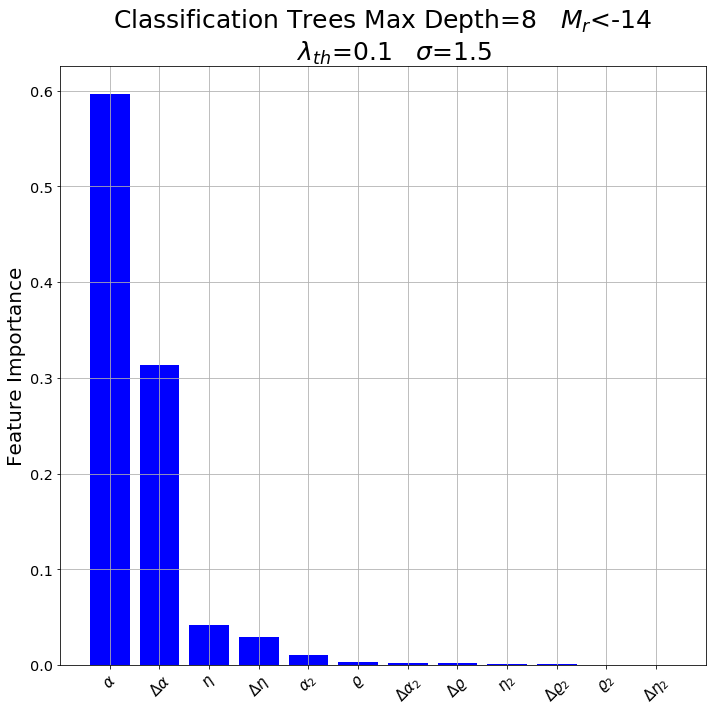

In [4]:
cuts=[-22,-20,-18,-16,-14,-12]               #cuts in r_abs
cuts_dict = {'-22':'1', '-20':'2', '-18':'3', '-16':'4', '-14':'5', '-12':'6' }            #cuts in r_abs
lambda_th = [0.0,0.1,0.2,0.3,0.4,0.5]        #lambda_th
smooth=[0.5,1,1.5,2,2.5]                         #Smooth
max_depth=np.linspace(1,30,30).astype(int)
max_depth=[10]
method = "Tree"

#--------------- Best parameters
lambda_th=[0.1]
smooth=[1.5]
cmap=plt.cm.Blues
MD = 8

pbar = tqdm(total=len(smooth)*len(lambda_th)*len(max_depth))
for ss in smooth:
    for ll in lambda_th:
        fig=plt.figure(figsize=(15,20))
        j = 0
        for cc in cuts[4:5]:
            ck = cuts_dict[str(cc)]
            
            print("Predicting Cosmic Web for lambda_th:"+str(ll)+" Mr<"+str(cc)+" sigma:"+str(ss))

            #------------------------ Reading B-skeleton catalog created with BSK_TNG.ipynb beta=1
            trainfilename = path+'/bsk_data/TNG/data_mock_Cr{}_lth{}_sm{}_train.csv'.format(ck,ll,ss)
            print(trainfilename)
            df_train = pd.read_csv(trainfilename)
            validfilename = path+'/bsk_data/TNG/data_mock_Cr{}_lth{}_sm{}_test.csv'.format(ck,ll,ss)
            print(validfilename)
            df_valid = pd.read_csv(validfilename)
            
            X_columns = ['nc','ad','den','Dnc','Dad','Dden','nc2','ad2','den2','Dnc2','Dad2','Dden2']
            Y_columns = ['env']
            
            Xx_train=np.array(df_train[X_columns])
            Xx_valid=np.array(df_valid[X_columns])
            Yy_train=np.array(df_train[Y_columns])
            Yy_valid=np.array(df_valid[Y_columns])

            f1s_av=[]
            f1s_peak=[]
            f1s_fila=[]
            f1s_sheet=[]
            f1s_void=[]
            for md in max_depth:
                clf = DecisionTreeClassifier(max_depth=md)
                clf.fit(Xx_train,Yy_train)
                Yy_pred=clf.predict(Xx_valid)
                f1s_av.append(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
                f1s_peak.append(f1_score(Yy_valid, Yy_pred, average=None)[0])
                f1s_fila.append(f1_score(Yy_valid, Yy_pred, average=None)[1])
                f1s_sheet.append(f1_score(Yy_valid, Yy_pred, average=None)[2])
                f1s_void.append(f1_score(Yy_valid, Yy_pred, average=None)[3])      

                pbar.update(1)

            f1s_av=np.array(f1s_av)
            f1s_peak=np.array(f1s_peak)
            f1s_fila=np.array(f1s_fila)
            f1s_sheet=np.array(f1s_sheet)
            f1s_void=np.array(f1s_void)
            
            ii = np.argmax(f1s_av) #max f1 average score
            print(round(f1s_av[ii],3))
            print(round(f1s_peak[ii],3))
            print(round(f1s_fila[ii],3))
            print(round(f1s_sheet[ii],3))
            print(round(f1s_void[ii],3))
            print(max_depth[ii])

            ax = fig.add_subplot(4,3,1+j)
            major_ticks = np.arange(0, 30, 10)
            plt.grid()
            plt.plot(max_depth,f1s_av,"o",label="Average")
            plt.legend()
            plt.xlabel("Max_Depth",size=20)
            plt.ylabel("F1_score",size=20)
            plt.ylim(0,1)

            ax = fig.add_subplot(4,3,2+j)
            plt.plot(max_depth,f1s_peak,"^",label="Peaks", c="red")
            plt.plot(max_depth,f1s_fila,"o",label="Filaments", c="orange")
            plt.plot(max_depth,f1s_sheet,"s",label="Sheets",c="green")
            plt.plot(max_depth,f1s_void,"X",label="Voids",c="black")
            plt.legend()
            plt.grid()
            plt.ylim(0,1)
            plt.xlabel("Max_Depth",size=20)
            plt.ylabel("F1_score",size=20)
            plt.tight_layout()

            ax = fig.add_subplot(4,3,3+j)
            _=plt.hist(Yy_valid)
            _=plt.xticks(np.arange(4),classes, rotation=45, size=15)        
            _=plt.xlabel("Environment",size=20)
            _=plt.ylabel("Counts",size=20)
            _=plt.yscale("log")
            _=plt.grid()
            _=plt.tight_layout()
            
            j += 3
            
        fig.suptitle('Environment Prediction '+str(method)+r' Classification  $M_r<$-14 $\lambda_{th}$='+str(ll)+' $\sigma$='+str(ss),size=22)
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
#         plt.savefig("../Figures/TNG/p_F1_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(14,7))
            clf = DecisionTreeClassifier(max_depth=MD)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            cm = confusion_matrix(Yy_valid, Yy_pred)
            classes = classes[unique_labels(Yy_valid, Yy_pred).astype(int)]
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            ax = fig.add_subplot(1,2,1)
            im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
            ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.74)
            ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes)
            ax.set_xlabel("Environment Predicted",size=20)
            ax.set_ylabel("Environment True",size=20)
            ax.set_ylim(4-0.5, -0.5)

            plt.setp(ax.get_xticklabels(), rotation=15, size=12)
            plt.setp(ax.get_yticklabels(), rotation=45, size=12)

            fmt = '.2f'
            thresh = cm.max()/2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")

            ## Importances
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]

            lfi=len(importances)
            features=np.array(list(['nc','ad','den','Dnc','Dad','Dden','nc2','ad2','den2','Dnc2','Dad2','Dden2']))
            features_tex=[r'$\eta$',r'$\alpha$',r'$\varrho$',r'$\Delta \eta$',r'$\Delta \alpha$',r'$\Delta \varrho $',
                         r'$\eta_2$',r'$\alpha_2$',r'$\varrho_2$',r'$\Delta \eta_2$',r'$\Delta \alpha_2$',r'$\Delta \varrho_2 $']

            # Plot the feature importances of the Tree
            ax = fig.add_subplot(1,2,2,aspect=13,rasterized=True)
            plt.bar(range(lfi), importances[indices], color="b", align="center") #, yerr=std[indices]
            plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=20)
            plt.grid()
            plt.ylabel("Feature Importance",size=20)
            plt.xlim([-1, lfi])

        fig.suptitle('Best Prediction\nMax Depth='+str(MD)+'   $M_{r}$<'+str(cc)+'   $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss)+'  $\\beta$=1',size=25)
        fig.subplots_adjust(top=0.97)
        fig.tight_layout()

#         plt.savefig("../Figures/TNG/p_CM_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True)
        plt.show()
        pbar.update(1)
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(10,10))
            clf = DecisionTreeClassifier(max_depth=MD)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            #title="CM - TNG_(Tree_Class) \n MD"+str(mm)+" r_abs<"+str(-12)+" lth"+str(lambda_th)+" sm"+str(ss)+" beta"+str(beta/1.0)
            cm = confusion_matrix(Yy_valid, Yy_pred)
            classes = classes[unique_labels(Yy_valid, Yy_pred).astype(int)]
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            ax = fig.add_subplot(1,1,1)
            im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
            ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.76)
            ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes)
            ax.set_xlabel("Environment Predicted",size=20)
            ax.set_ylabel("Environment True",size=20)
            ax.set_ylim(4-0.5, -0.5)
            fig.suptitle('Max Depth='+str(MD)+'   $M_{r}$<'+str(cc)+'  \n $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss),size=25)

            plt.setp(ax.get_xticklabels(), rotation=15, size=15)
            plt.setp(ax.get_yticklabels(), rotation=45, size=15)

            fmt = '.2f'
            thresh = cm.max()/2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")


        fig.tight_layout()

#         plt.savefig("../Figures/TNG/p_CM_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
        pbar.update(1)
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(10,10))
            clf = DecisionTreeClassifier(max_depth=MD)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            ## Importances
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]

            lfi=len(importances)
            features=np.array(list(['nc','ad','den','Dnc','Dad','Dden','nc2','ad2','den2','Dnc2','Dad2','Dden2']))
            features_tex=[r'$\eta$',r'$\alpha$',r'$\varrho$',r'$\Delta \eta$',r'$\Delta \alpha$',r'$\Delta \varrho $',
                         r'$\eta_2$',r'$\alpha_2$',r'$\varrho_2$',r'$\Delta \eta_2$',r'$\Delta \alpha_2$',r'$\Delta \varrho_2 $']
            #print(list(np.array(features)))

            # Plot the feature importances of the Tree
            ax = fig.add_subplot(1,1,1)
            plt.bar(range(lfi), importances[indices], color="b", align="center") #, yerr=std[indices]
            plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=15)
            plt.grid()
            plt.title('Classification Trees Max Depth='+str(MD)+'   $M_{r}$<'+str(cc)+'\n   $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss),size=25)
            plt.ylabel("Feature Importance",size=20)
            plt.xlim([-1, lfi])
            
        fig.subplots_adjust(top=0.9)
        fig.tight_layout()

        plt.savefig("../Figures/TNG/p_FI_EnvPred"+str(method)+"Class_beta2.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
        pbar.update(1)
pbar.close()

# Claim 1 beta=2 Forest

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
import pickle

Predicting Cosmic Web for lambda_th:0.1 Mr<-14 sigma:1.5
../../bsk_data/TNG/data_mock_Cr5_lth0.1_sm1.5_train.csv
../../bsk_data/TNG/data_mock_Cr5_lth0.1_sm1.5_test.csv
0.553
0.685
0.74
0.621
0.167
80


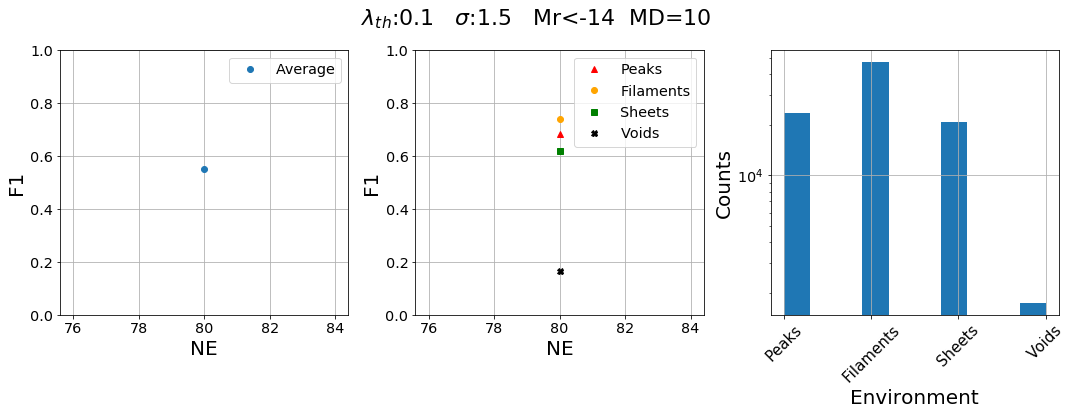

0.5532501275271767
0.6854408684060178
0.7398461931829358
0.6210467818530867
0.16666666666666669


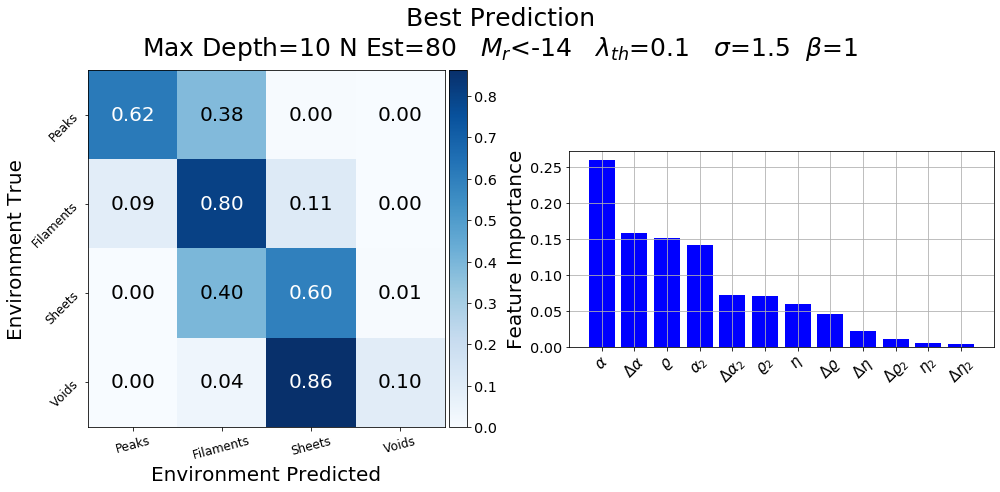

0.5532501275271767
0.6854408684060178
0.7398461931829358
0.6210467818530867
0.16666666666666669


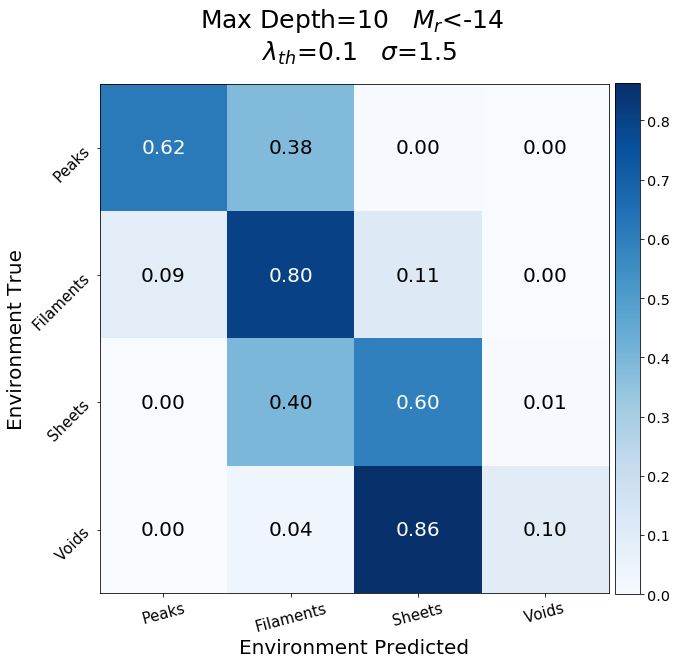

0.5532501275271767
0.6854408684060178
0.7398461931829358
0.6210467818530867
0.16666666666666669


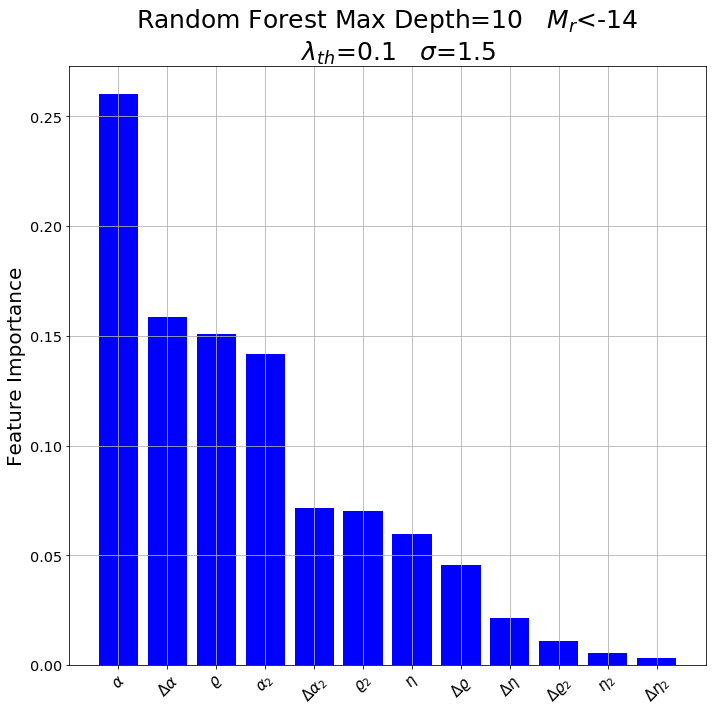

In [6]:
cuts=[-22,-20,-18,-16,-14,-12]               #cuts in r_abs
lambda_th = [0.0,0.1,0.2,0.3,0.4,0.5]        #lambda_th
cuts_dict = {'-22':'1', '-20':'2', '-18':'3', '-16':'4', '-14':'5', '-12':'6' }            #cuts in r_abs
smooth=[0.5,1,1.5,2,2.5]                         #Smooth
n_estimators=np.linspace(1,101,10).astype(int)
n_estimators=[80]
MD = 10
method = "Forest"

#--------------- Best parameters
lambda_th=[0.1]
smooth=[1.5]
NE = 80
cmap=plt.cm.Blues

pbar = tqdm(total=len(smooth)*len(lambda_th)*len(n_estimators))
for ss in smooth:
    for ll in lambda_th:
        fig=plt.figure(figsize=(15,20))
        j = 0
        for cc in cuts[4:5]:
            ck = cuts_dict[str(cc)]
            
            print("Predicting Cosmic Web for lambda_th:"+str(ll)+" Mr<"+str(cc)+" sigma:"+str(ss))

            #------------------------ Reading B-skeleton catalog created with BSK_TNG.ipynb beta=1
            trainfilename = path+'/bsk_data/TNG/data_mock_Cr{}_lth{}_sm{}_train.csv'.format(ck,ll,ss)
            print(trainfilename)
            df_train = pd.read_csv(trainfilename)
            validfilename = path+'/bsk_data/TNG/data_mock_Cr{}_lth{}_sm{}_test.csv'.format(ck,ll,ss)
            print(validfilename)
            df_valid = pd.read_csv(validfilename)
            
            X_columns = ['nc','ad','den','Dnc','Dad','Dden','nc2','ad2','den2','Dnc2','Dad2','Dden2']
            Y_columns = ['env']
            
            Xx_train=np.array(df_train[X_columns])
            Xx_valid=np.array(df_valid[X_columns])
            Yy_train=np.array(df_train[Y_columns])
            Yy_valid=np.array(df_valid[Y_columns])


            f1s_av=[]
            f1s_peak=[]
            f1s_fila=[]
            f1s_sheet=[]
            f1s_void=[]
            for ne in n_estimators: 
                clf = RandomForestClassifier(max_depth=MD,n_estimators=ne,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
                clf.fit(Xx_train,Yy_train)
                Yy_pred=clf.predict(Xx_valid)  
                f1s_av.append(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
                f1s_peak.append(f1_score(Yy_valid, Yy_pred, average=None)[0])
                f1s_fila.append(f1_score(Yy_valid, Yy_pred, average=None)[1])
                f1s_sheet.append(f1_score(Yy_valid, Yy_pred, average=None)[2])
                f1s_void.append(f1_score(Yy_valid, Yy_pred, average=None)[3])      

                pbar.update(1)

            f1s_av=np.array(f1s_av)
            f1s_peak=np.array(f1s_peak)
            f1s_fila=np.array(f1s_fila)
            f1s_sheet=np.array(f1s_sheet)
            f1s_void=np.array(f1s_void)
            
            ii = np.argmax(f1s_av) #max f1 average score
            print(round(f1s_av[ii],3))
            print(round(f1s_peak[ii],3))
            print(round(f1s_fila[ii],3))
            print(round(f1s_sheet[ii],3))
            print(round(f1s_void[ii],3))
            print(n_estimators[ii])

            ax = fig.add_subplot(4,3,1+j)
            major_ticks = np.arange(0, 30, 10)
            plt.grid()
            plt.plot(n_estimators,f1s_av,"o",label="Average")
            plt.legend()
            plt.xlabel("NE",size=20)
            plt.ylabel("F1",size=20)
            plt.ylim(0,1)

            ax = fig.add_subplot(4,3,2+j)
            plt.plot(n_estimators,f1s_peak,"^",label="Peaks", c="red")
            plt.plot(n_estimators,f1s_fila,"o",label="Filaments", c="orange")
            plt.plot(n_estimators,f1s_sheet,"s",label="Sheets",c="green")
            plt.plot(n_estimators,f1s_void,"X",label="Voids",c="black")
            plt.legend()
            plt.grid()
            plt.ylim(0,1)
            plt.xlabel("NE",size=20)
            plt.ylabel("F1",size=20)
            plt.tight_layout()

            ax = fig.add_subplot(4,3,3+j)
            _=plt.hist(Yy_valid)
            _=plt.xticks(np.arange(4),classes, rotation=45, size=15)        
            _=plt.xlabel("Environment",size=20)
            _=plt.ylabel("Counts",size=20)
            _=plt.yscale("log")
            _=plt.grid()
            _=plt.tight_layout()
            
            j += 3
            
        fig.suptitle("$\lambda_{th}$:"+str(ll)+"   $\sigma$:"+str(ss)+"   Mr<-14  MD=10",size=22)
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig("../Figures/TNG/p_F1_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(14,7))
            clf = RandomForestClassifier(max_depth=MD,n_estimators=NE,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            #title="CM - TNG_(Tree_Class) \n MD"+str(mm)+" r_abs<"+str(-12)+" lth"+str(lambda_th)+" sm"+str(ss)+" beta"+str(beta/1.0)
            cm = confusion_matrix(Yy_valid, Yy_pred)
            classes = classes[unique_labels(Yy_valid, Yy_pred).astype(int)]
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            ax = fig.add_subplot(1,2,1)
            im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
            ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.74)
            ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes)
            ax.set_xlabel("Environment Predicted",size=20)
            ax.set_ylabel("Environment True",size=20)
            ax.set_ylim(4-0.5, -0.5)

            plt.setp(ax.get_xticklabels(), rotation=15, size=12)
            plt.setp(ax.get_yticklabels(), rotation=45, size=12)

            fmt = '.2f'
            thresh = cm.max()/2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")

            ## Importances
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]

            lfi=len(importances)
            features=np.array(list(['nc','ad','den','Dnc','Dad','Dden',
                                    'nc2','ad2','den2','Dnc2','Dad2','Dden2']))
            features_tex=[r'$\eta$',r'$\alpha$',r'$\varrho$',r'$\Delta \eta$',r'$\Delta \alpha$',r'$\Delta \varrho$',
                         r'$\eta_2$',r'$\alpha_2$',r'$\varrho_2$',r'$\Delta \eta_2$',r'$\Delta \alpha_2$',r'$\Delta \varrho_2$']
            #print(list(np.array(features)))

            # Plot the feature importances of the Tree
            ax = fig.add_subplot(1,2,2,aspect=22,rasterized=True)
            plt.bar(range(lfi), importances[indices], color="b", align="center") #, yerr=std[indices]
            plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=15)
            plt.grid()
            plt.ylabel("Feature Importance",size=20)
            plt.xlim([-1, lfi])

        fig.suptitle('Best Prediction\nMax Depth='+str(MD)+' N Est='+str(NE)+'   $M_{r}$<'+str(cc)+'   $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss)+'  $\\beta$=1',size=25)
        fig.subplots_adjust(top=0.97)
        fig.tight_layout()

        plt.savefig("../Figures/TNG/p_CM_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True)
        plt.show()
        pbar.update(1)
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(10,10))
            clf = RandomForestClassifier(max_depth=MD,n_estimators=NE,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            #title="CM - TNG_(Tree_Class) \n MD"+str(mm)+" r_abs<"+str(-12)+" lth"+str(lambda_th)+" sm"+str(ss)+" beta"+str(beta/1.0)
            cm = confusion_matrix(Yy_valid, Yy_pred)
            classes = classes[unique_labels(Yy_valid, Yy_pred).astype(int)]
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            ax = fig.add_subplot(1,1,1)
            im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
            ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.76)
            ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes)
            ax.set_xlabel("Environment Predicted",size=20)
            ax.set_ylabel("Environment True",size=20)
            ax.set_ylim(4-0.5, -0.5)
            fig.suptitle('Max Depth='+str(MD)+'   $M_{r}$<'+str(cc)+'  \n $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss),size=25)

            plt.setp(ax.get_xticklabels(), rotation=15, size=15)
            plt.setp(ax.get_yticklabels(), rotation=45, size=15)

            fmt = '.2f'
            thresh = cm.max()/2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")


        fig.tight_layout()

        plt.savefig("../Figures/TNG/p_CM_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
        pbar.update(1)
pbar.close()


pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(10,10))
            clf = RandomForestClassifier(max_depth=MD,n_estimators=NE,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            ## Importances
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]

            lfi=len(importances)
            features=np.array(list(['nc','ad','den','Dnc','Dad','Dden',
                                    'nc2','ad2','den2','Dnc2','Dad2','Dden2']))
            features_tex=[r'$\eta$',r'$\alpha$',r'$\varrho$',r'$\Delta \eta$',r'$\Delta \alpha$',r'$\Delta \varrho$',
                         r'$\eta_2$',r'$\alpha_2$',r'$\varrho_2$',r'$\Delta \eta_2$',r'$\Delta \alpha_2$',r'$\Delta \varrho_2$']
            #print(list(np.array(features)))

            # Plot the feature importances of the Tree
            ax = fig.add_subplot(1,1,1)
            plt.bar(range(lfi), importances[indices], color="b", align="center") #, yerr=std[indices]
            plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=15)
            plt.grid()
            plt.title('Random Forest Max Depth='+str(MD)+'   $M_{r}$<'+str(cc)+'\n   $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss),size=25)
            plt.ylabel("Feature Importance",size=20)
            plt.xlim([-1, lfi])
            
        fig.subplots_adjust(top=0.9)
        fig.tight_layout()

        plt.savefig("../Figures/TNG/p_FI_EnvPred"+str(method)+"Class_beta2.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
        pbar.update(1)
pbar.close()

# Claim 2 Importance Mr

Predicting Cosmic Web for lambda_th:0.1 Mr<-14 sigma:1.5
../../bsk_data/TNG/data_mock_Cr5_lth0.1_sm1.5_train.csv
../../bsk_data/TNG/data_mock_Cr5_lth0.1_sm1.5_valid.csv
0.55
0.686
0.735
0.612
0.167
80


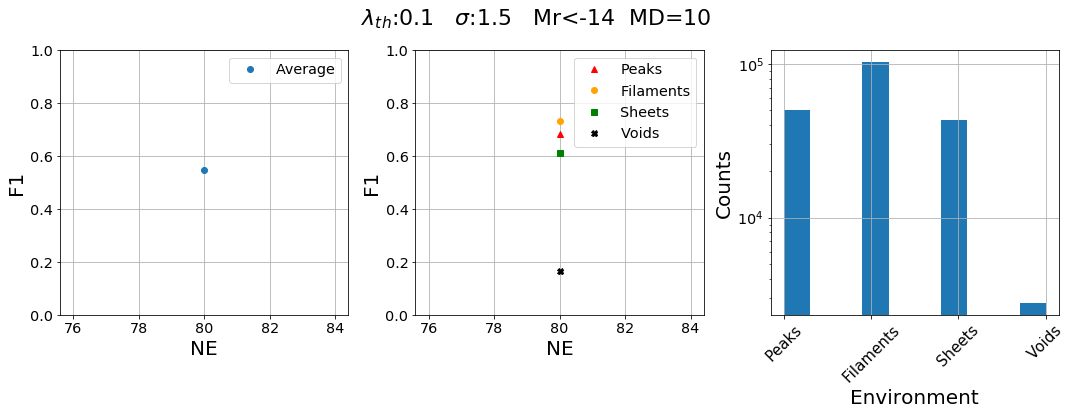

0.5496154138229317
0.6855577700332913
0.7346722173932934
0.6117147466312393
0.16651692123390238


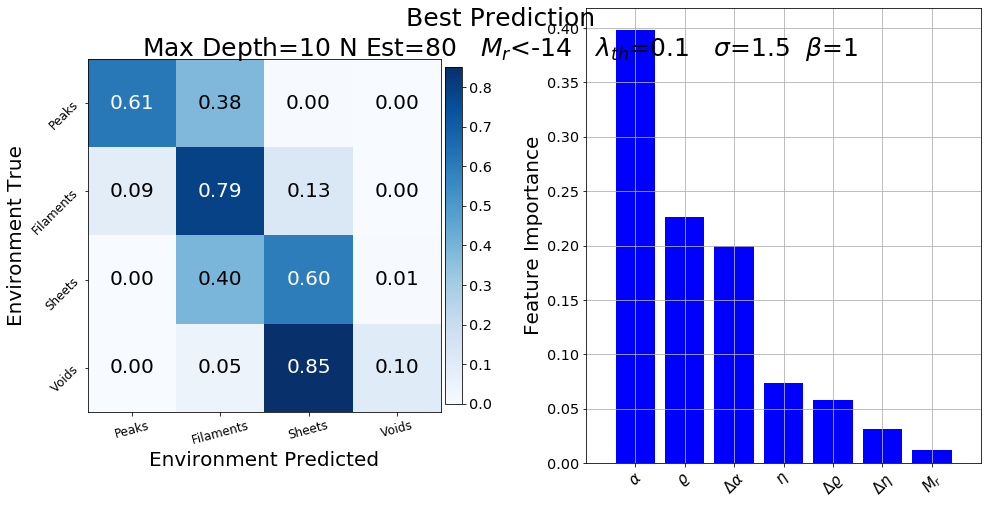

0.5496154138229317
0.6855577700332913
0.7346722173932934
0.6117147466312393
0.16651692123390238


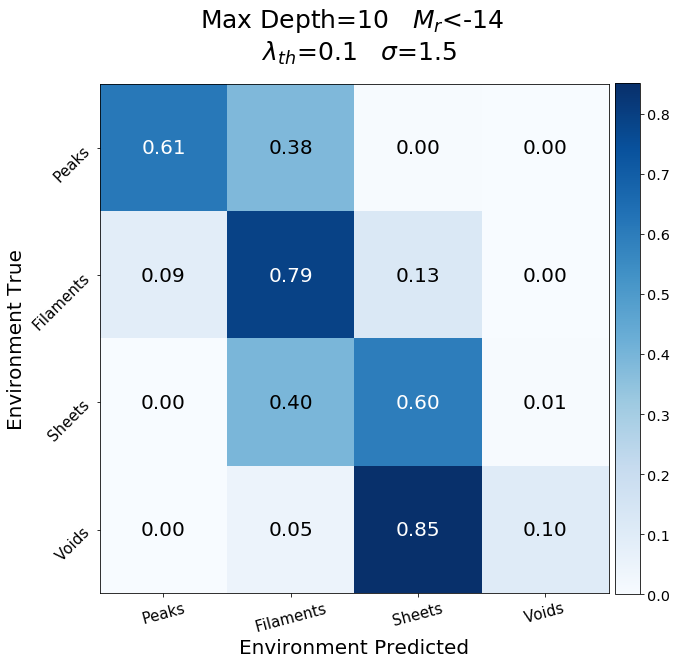

0.5496154138229317
0.6855577700332913
0.7346722173932934
0.6117147466312393
0.16651692123390238


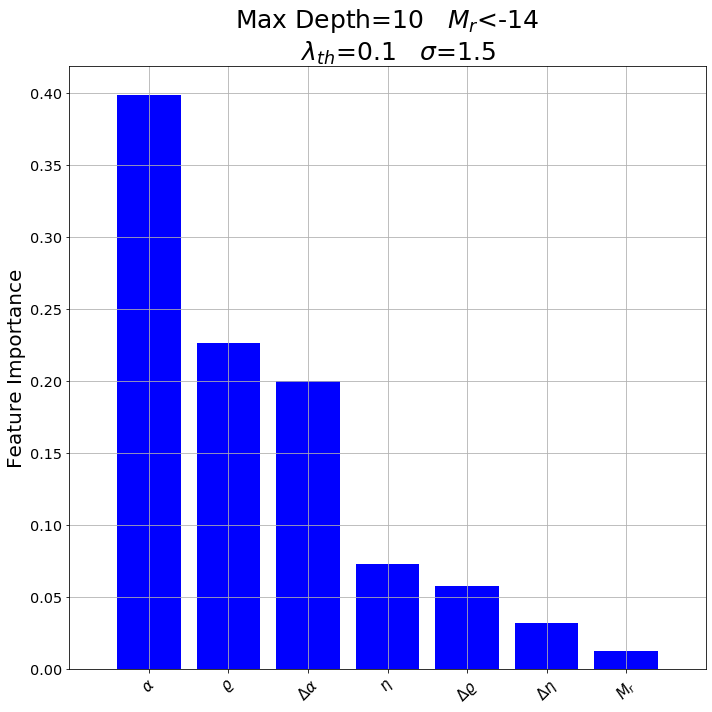

In [7]:
cuts=[-22,-20,-18,-16,-14,-12]               #cuts in r_abs
lambda_th = [0.0,0.1,0.2,0.3,0.4,0.5]        #lambda_th
cuts_dict = {'-22':'1', '-20':'2', '-18':'3', '-16':'4', '-14':'5', '-12':'6' }            #cuts in r_abs
smooth=[0.5,1,1.5,2,2.5]                         #Smooth
n_estimators=np.linspace(1,101,10).astype(int)
n_estimators=[80]
MD = 10
method = 'Forest'

#--------------- Best parameters
lambda_th=[0.1]
smooth=[1.5]
NE = 80
cmap=plt.cm.Blues

pbar = tqdm(total=len(smooth)*len(lambda_th)*len(n_estimators))
for ss in smooth:
    for ll in lambda_th:
        fig=plt.figure(figsize=(15,20))
        j = 0
        for cc in cuts[4:5]:
            ck = cuts_dict[str(cc)]
            
            print("Predicting Cosmic Web for lambda_th:"+str(ll)+" Mr<"+str(cc)+" sigma:"+str(ss))

            #------------------------ Reading B-skeleton catalog created with BSK_TNG.ipynb beta=1
            trainfilename = path+'/bsk_data/TNG/data_mock_Cr{}_lth{}_sm{}_train.csv'.format(ck,ll,ss)
            print(trainfilename)
            df_train = pd.read_csv(trainfilename)
            validfilename = path+'/bsk_data/TNG/data_mock_Cr{}_lth{}_sm{}_valid.csv'.format(ck,ll,ss)
            print(validfilename)
            df_valid = pd.read_csv(validfilename)
            
            X_columns = ['nc','ad','den','Dnc','Dad','Dden','Mr']
            Y_columns = ['env']
            
            Xx_train=np.array(df_train[X_columns])
            Xx_valid=np.array(df_valid[X_columns])
            Yy_train=np.array(df_train[Y_columns])
            Yy_valid=np.array(df_valid[Y_columns])


            f1s_av=[]
            f1s_peak=[]
            f1s_fila=[]
            f1s_sheet=[]
            f1s_void=[]
            for ne in n_estimators: 
                clf = RandomForestClassifier(max_depth=MD,n_estimators=ne,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
                clf.fit(Xx_train,Yy_train)
                Yy_pred=clf.predict(Xx_valid)  
                f1s_av.append(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
                f1s_peak.append(f1_score(Yy_valid, Yy_pred, average=None)[0])
                f1s_fila.append(f1_score(Yy_valid, Yy_pred, average=None)[1])
                f1s_sheet.append(f1_score(Yy_valid, Yy_pred, average=None)[2])
                f1s_void.append(f1_score(Yy_valid, Yy_pred, average=None)[3])      

                pbar.update(1)

            f1s_av=np.array(f1s_av)
            f1s_peak=np.array(f1s_peak)
            f1s_fila=np.array(f1s_fila)
            f1s_sheet=np.array(f1s_sheet)
            f1s_void=np.array(f1s_void)
            
            ii = np.argmax(f1s_av) #max f1 average score
            print(round(f1s_av[ii],3))
            print(round(f1s_peak[ii],3))
            print(round(f1s_fila[ii],3))
            print(round(f1s_sheet[ii],3))
            print(round(f1s_void[ii],3))
            print(n_estimators[ii])

            ax = fig.add_subplot(4,3,1+j)
            major_ticks = np.arange(0, 30, 10)
            plt.grid()
            plt.plot(n_estimators,f1s_av,"o",label="Average")
            plt.legend()
            plt.xlabel("NE",size=20)
            plt.ylabel("F1",size=20)
            plt.ylim(0,1)

            ax = fig.add_subplot(4,3,2+j)
            plt.plot(n_estimators,f1s_peak,"^",label="Peaks", c="red")
            plt.plot(n_estimators,f1s_fila,"o",label="Filaments", c="orange")
            plt.plot(n_estimators,f1s_sheet,"s",label="Sheets",c="green")
            plt.plot(n_estimators,f1s_void,"X",label="Voids",c="black")
            plt.legend()
            plt.grid()
            plt.ylim(0,1)
            plt.xlabel("NE",size=20)
            plt.ylabel("F1",size=20)
            plt.tight_layout()

            ax = fig.add_subplot(4,3,3+j)
            _=plt.hist(Yy_valid)
            _=plt.xticks(np.arange(4),classes, rotation=45, size=15)        
            _=plt.xlabel("Environment",size=20)
            _=plt.ylabel("Counts",size=20)
            _=plt.yscale("log")
            _=plt.grid()
            _=plt.tight_layout()
            
            j += 3
            
        fig.suptitle("$\lambda_{th}$:"+str(ll)+"   $\sigma$:"+str(ss)+"   Mr<-14  MD=10",size=22)
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.savefig("../Figures/TNG/p_F1_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(14,7))
            clf = RandomForestClassifier(max_depth=MD,n_estimators=NE,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            #title="CM - TNG_(Tree_Class) \n MD"+str(mm)+" r_abs<"+str(-12)+" lth"+str(lambda_th)+" sm"+str(ss)+" beta"+str(beta/1.0)
            cm = confusion_matrix(Yy_valid, Yy_pred)
            classes = classes[unique_labels(Yy_valid, Yy_pred).astype(int)]
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            ax = fig.add_subplot(1,2,1)
            im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
            ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.74)
            ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes)
            ax.set_xlabel("Environment Predicted",size=20)
            ax.set_ylabel("Environment True",size=20)
            ax.set_ylim(4-0.5, -0.5)

            plt.setp(ax.get_xticklabels(), rotation=15, size=12)
            plt.setp(ax.get_yticklabels(), rotation=45, size=12)

            fmt = '.2f'
            thresh = cm.max()/2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")

            ## Importances
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]

            lfi=len(importances)
            features=np.array(list(['nc','ad','den','Dnc','Dad','Dden','Mr']))
            features_tex=[r'$\eta$',r'$\alpha$',r'$\varrho$',r'$\Delta \eta$',r'$\Delta \alpha$',r'$\Delta \varrho$',r'$M_r$']
            #print(list(np.array(features)))

            # Plot the feature importances of the Tree
            ax = fig.add_subplot(1,2,2,aspect=22,rasterized=True)
            plt.bar(range(lfi), importances[indices], color="b", align="center") #, yerr=std[indices]
            plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=15)
            plt.grid()
            plt.ylabel("Feature Importance",size=20)
            plt.xlim([-1, lfi])

        fig.suptitle('Best Prediction\nMax Depth='+str(MD)+' N Est='+str(NE)+'   $M_{r}$<'+str(cc)+'   $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss)+'  $\\beta$=1',size=25)
        fig.subplots_adjust(top=0.97)
        fig.tight_layout()

        plt.savefig("../Figures/TNG/p_CM_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True)
        plt.show()
        pbar.update(1)
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(10,10))
            clf = RandomForestClassifier(max_depth=MD,n_estimators=NE,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            #title="CM - TNG_(Tree_Class) \n MD"+str(mm)+" r_abs<"+str(-12)+" lth"+str(lambda_th)+" sm"+str(ss)+" beta"+str(beta/1.0)
            cm = confusion_matrix(Yy_valid, Yy_pred)
            classes = classes[unique_labels(Yy_valid, Yy_pred).astype(int)]
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            ax = fig.add_subplot(1,1,1)
            im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
            ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.76)
            ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes)
            ax.set_xlabel("Environment Predicted",size=20)
            ax.set_ylabel("Environment True",size=20)
            ax.set_ylim(4-0.5, -0.5)
            fig.suptitle('Max Depth='+str(MD)+'   $M_{r}$<'+str(cc)+'  \n $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss),size=25)

            plt.setp(ax.get_xticklabels(), rotation=15, size=15)
            plt.setp(ax.get_yticklabels(), rotation=45, size=15)

            fmt = '.2f'
            thresh = cm.max()/2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")


        fig.tight_layout()

        plt.savefig("../Figures/TNG/p_CM_EnvPred"+str(method)+"Class.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
        pbar.update(1)
pbar.close()

pbar=tqdm(total=len(smooth)*len(lambda_th))
for ss in smooth:
    for ll in lambda_th:
        for cc in cuts[4:5]:
            cut = cuts_dict[str(cc)]

            fig= plt.figure(figsize=(10,10))
            clf = RandomForestClassifier(max_depth=MD,n_estimators=NE,criterion='gini',
                                             min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,random_state=42)
            clf.fit(Xx_train,Yy_train)
            Yy_pred=clf.predict(Xx_valid)
            
            print(np.average(f1_score(Yy_valid, Yy_pred, average=None)))
            print(f1_score(Yy_valid, Yy_pred, average=None)[0])
            print(f1_score(Yy_valid, Yy_pred, average=None)[1])
            print(f1_score(Yy_valid, Yy_pred, average=None)[2])
            print(f1_score(Yy_valid, Yy_pred, average=None)[3])

            ## Importances
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]

            lfi=len(importances)
            features=np.array(list(['nc','ad','den','Dnc','Dad','Dden','Mr']))
            features_tex=[r'$\eta$',r'$\alpha$',r'$\varrho$',r'$\Delta \eta$',r'$\Delta \alpha$',r'$\Delta \varrho$',r'$M_r$']
            #print(list(np.array(features)))

            # Plot the feature importances of the Tree
            ax = fig.add_subplot(1,1,1)
            plt.bar(range(lfi), importances[indices], color="b", align="center") #, yerr=std[indices]
            plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=15)
            plt.grid()
            plt.title('Max Depth='+str(MD)+'   $M_{r}$<'+str(cc)+'\n   $\lambda_{th}$='+str(ll)+'   $\sigma$='+str(ss),size=25)
            plt.ylabel("Feature Importance",size=20)
            plt.xlim([-1, lfi])
            
        fig.subplots_adjust(top=0.9)
        fig.tight_layout()

        plt.savefig("../Figures/TNG/p_FI_EnvPred"+str(method)+"Class_Mr.pdf",transparent=True, rasterized=True, bbox_inches='tight')
        plt.show()
        pbar.update(1)
pbar.close()

# Claim 4 F1 weighted

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
import pandas as pd
from tabulate import tabulate

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
font = {'family' : 'serif',
        'size'   : 20}
mpl.rc('font', **font)
mpl.rcParams.update({'figure.autolayout': False})


from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

def PCF(CM):
    pre = np.zeros(4)
    rec = np.zeros(4)
    f1 = np.zeros(4)
    n_items = np.zeros(4)
    for i in range(4):
        pre[i] = CM[i][i]/sum(CM[i])
        rec[i] = CM[i][i]/sum(CM.T[i])
        n_items[i] = sum(CM.T[i])
        f1[i] = 2*pre[i]*rec[i]/(pre[i]+rec[i])
    f1 = np.nan_to_num(f1)
    # El orden en los arrays de 4 es: peak, fila, sheet, void
    return pre, rec, f1, n_items

In [3]:
path = '../..'
def compute_F1(method="Forest"):
    filename = './Results/features_prediction_'+str(method)+'_box.hdf5'
    f = h5py.File(filename, 'r')
    print(f.keys())
    data = {}
    for k in f.keys():
        data[k] = f[k][...]
    f.close()

    C = data['C']
    F1_av = data['F1']
    F1_peak = data['F1_peak']
    F1_fila = data['F1_fila']
    F1_sheet = data['F1_sheet']
    F1_void = data['F1_void']

    F1_weighted = np.ones(len(C))
    F1_av_no_voids = np.ones(len(C))
    for i in range(len(C)):
        p,r, f1, n_items = PCF(C[i])
        F1_weighted[i] = np.sum(f1*n_items)/np.sum(n_items)
        F1_av_no_voids[i] = np.mean(f1[0:3])
        if data['F1'][i] != np.mean(f1):
            print(data[i]['F1'])
            print(np.mean(f1),end="\n\n")
        if data['F1_peak'][i]!= f1[0]:
            print(data[i]['F1_peak'])
            print(f1[0],end="\n\n")
    columna = {"Forest":"NE", "Tree":"MD", "SVM":"MI"}
    return {'F1_peak': F1_peak,'F1_fila': F1_fila,'F1_sheet': F1_sheet,'F1_void': F1_void, 'F1_av': F1_av, 'F1_av_no_voids':F1_av_no_voids, 'F1_weighted':F1_weighted, 
            'R':data['R'], 'S':data['S'], 'C':data['C'], 'L':data['L'], 'NP': data[columna[method]]}

In [4]:
F1 = {}
methods = ["Forest", "Tree"]
for m in methods:
    F1[m] = compute_F1(method=m)

<KeysViewHDF5 ['C', 'F1', 'F1_fila', 'F1_peak', 'F1_sheet', 'F1_void', 'G', 'L', 'NE', 'R', 'S']>
<KeysViewHDF5 ['C', 'F1', 'F1_fila', 'F1_peak', 'F1_sheet', 'F1_void', 'G', 'L', 'MD', 'R', 'S']>
